# Stock Trend Prediction using Technical Indicators

In [521]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Data Preprocessing

- Load in the csv data

In [522]:
features = pd.read_csv('data/ge.csv')
#index_es = pd.read_csv('data/s&p500.csv')
#index_es = index_es.iloc[-features.shape[0]:,].reset_index(drop=True)
#index_nq = pd.read_csv('data/nasdaq.csv')
#index_nq = index_nq.iloc[-features.shape[0]:,].reset_index(drop=True)
#features = pd.concat([features, index_es], axis=1)
#features = pd.concat([features, index_nq], axis=1)

features.head(5)

,Open,High,Low,Adj Close,Volume
0,0.751202,0.763722,0.743690,0.001789,2156500
1,0.744942,0.744942,0.738682,0.001771,1477600
2,0.741186,0.747446,0.726162,0.001750,1837100
3,0.732422,0.733674,0.701122,0.001705,2725600
4,0.713642,0.713642,0.691106,0.001702,3095000


- Plot the stock data

In [523]:
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

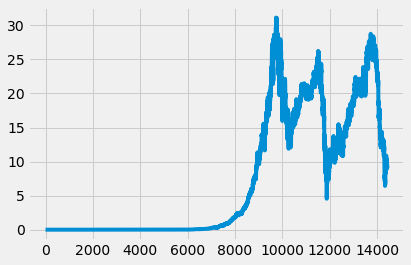

In [524]:
plt.plot(features['Adj Close'])

- Add technical indicators as features

In [525]:
# Simple Moving Averages
features['SMA5'] = features['Adj Close'].rolling(window=5).mean()
features['SMA10'] = features['Adj Close'].rolling(window=10).mean()
features['SMA20'] = features['Adj Close'].rolling(window=20).mean()
features['SMA50'] = features['Adj Close'].rolling(window=50).mean()
features['SMA200'] = features['Adj Close'].rolling(window=200).mean()
features['SMA50-200'] = features['SMA50'] - features['SMA200']

In [526]:
# Relative Strength Index
delta = features['Adj Close'].diff()
dUp, dDown = delta.copy(), delta.copy()
dUp[dUp < 0] = 0
dDown[dDown > 0] = 0
RolUp = dUp.rolling(window=14).mean()
RolDown = dDown.rolling(window=14).mean().abs()
RS = RolUp / RolDown
features['RSI'] = 100 - 100 / (1 + RS)

In [527]:
# Stochastic Oscillator
L14 = features['Low'].rolling(window=14).min()
H14 = features['High'].rolling(window=14).max()
features['%K'] = 100 * (features['Adj Close'] - L14) / (H14 - L14)

In [528]:
# Williams %R
features['%R'] = (H14 - features['Adj Close']) / (H14 - L14) * (-100)

In [529]:
# Moving Average Convergence Divergence
ema12 = features['Adj Close'].ewm(span=12, adjust=False).mean()
ema26 = features['Adj Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
ema9 = macd.ewm(span=9, adjust=False).mean()
features['MACDhist'] = macd - ema9

In [530]:
# Price Rate of Change
features['ROC'] = (features['Adj Close'] - features['Adj Close'].shift(12)) / features['Adj Close'].shift(12) * 100

In [531]:
# On Balance Volume
i = 0
obv = [0]
while i < features.index[-1]:
    diff = features.loc[i + 1, 'Adj Close'] - features.loc[i, 'Adj Close']
    if diff > 0:
        obv.append(obv[i] + features.loc[i + 1, 'Volume'])
    if diff == 0:
        obv.append(obv[i])
    if diff < 0:
        obv.append(obv[i] - features.loc[i + 1, 'Volume'])
    i += 1
features['OBV'] = pd.Series(obv)

In [532]:
# Trend labels
#features['Trend'] = features['Adj Close'] < features['Adj Close'].shift(-1)
features['Trend'] = features['Adj Close'] < features['SMA50'].shift(-50)
features.replace(True, 1, inplace=True)
features.replace(False, -1, inplace=True)
features['Trend'] = features['Trend'].astype(int)

In [533]:
# Drop the first 199 datapoints where some features are NaN
features = features.iloc[199:,]
features.tail(10)

,Open,High,Low,Adj Close,Volume,SMA5,SMA10,SMA20,SMA50,SMA200,SMA50-200,RSI,%K,%R,MACDhist,ROC,OBV,Trend
14418,9.15,9.21,8.99,9.00,68461200,9.198,9.647,9.8575,9.886081,10.258561,-0.372480,28.217822,0.775194,-99.224806,-0.137667,-9.638554,1772683300,-1
14419,9.01,9.05,8.79,8.98,82946700,9.096,9.535,9.7965,9.869927,10.237169,-0.367243,19.230769,12.751678,-87.248322,-0.136049,-9.201213,1689736600,-1
14420,9.04,9.19,8.99,9.14,60236000,9.080,9.425,9.7440,9.856588,10.217195,-0.360607,27.717391,23.489933,-76.510067,-0.117053,-8.508509,1749972600,-1
14421,9.16,9.18,9.06,9.12,48065100,9.072,9.327,9.6890,9.834781,10.198166,-0.363385,28.491620,22.147651,-77.852349,-0.099380,-9.702970,1701907500,-1
14422,9.13,9.35,9.10,9.35,51509100,9.118,9.259,9.6430,9.820648,10.181427,-0.360778,33.333333,37.583893,-62.416107,-0.067282,-8.691406,1753416600,-1
14423,9.25,9.35,9.18,9.32,67122500,9.182,9.190,9.6100,9.813792,10.164537,-0.350746,28.804348,35.570470,-64.429530,-0.044265,-7.722772,1686294100,-1
14424,9.30,9.37,9.22,9.33,40504600,9.252,9.174,9.5825,9.811937,10.147413,-0.335475,23.391813,36.241611,-63.758389,-0.025492,-6.979063,1726798700,-1
14425,9.31,9.35,9.21,9.32,28785100,9.288,9.184,9.5435,9.805657,10.128244,-0.322587,25.316456,39.259259,-60.740741,-0.011582,-6.893107,1698013600,-1
14426,9.22,9.23,8.98,9.12,62378000,9.288,9.180,9.5015,9.796337,10.107600,-0.311263,23.391813,24.444444,-75.555556,-0.013548,-3.898841,1635635600,-1
14427,9.12,9.59,9.11,9.57,73550600,9.332,9.225,9.4855,9.788525,10.088162,-0.299637,39.719626,97.500000,-2.500000,0.016150,3.796095,1709186200,-1


In [534]:
features.shape

(14229, 18)

In [535]:
# Split features and labels
labels = features['Trend']
features = features.drop('Trend', axis=1)

# Split training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (11383, 17)
Training Labels Shape: (11383,)
Testing Features Shape: (2846, 17)
Testing Labels Shape: (2846,)


### Train Model

In [536]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=1000)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Make Predictions on the Test Set

In [537]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate accuracy and F1 score
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
print('Accuracy:', accuracy)
print('F1:', f1)

Accuracy: 0.9571328179901616
F1: 0.9649223691776884


In [538]:
predictions[-50:,]

array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,
        1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,
        1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1])

### Variable Importances

In [539]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_list = list(features.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SMA200               Importance: 0.13
Variable: SMA50-200            Importance: 0.1
Variable: OBV                  Importance: 0.09
Variable: Adj Close            Importance: 0.08
Variable: SMA50                Importance: 0.08
Variable: SMA20                Importance: 0.07
Variable: High                 Importance: 0.06
Variable: Low                  Importance: 0.06
Variable: SMA5                 Importance: 0.06
Variable: SMA10                Importance: 0.06
Variable: Open                 Importance: 0.05
Variable: %K                   Importance: 0.04
Variable: %R                   Importance: 0.04
Variable: RSI                  Importance: 0.03
Variable: ROC                  Importance: 0.03
Variable: Volume               Importance: 0.02
Variable: MACDhist             Importance: 0.02


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]